In [1]:
import matplotlib.pyplot as plt
import numpy as np
import h_transport_materials as htm
from labellines import labelLines

In [2]:
htm.ureg.define('fraction = [] = frac')
htm.ureg.define('ppm = 1e-6 fraction')

MOLAR_VOL_RT = 24.45 * htm.ureg.L * htm.ureg.mol**-1
MOLAR_MASS_H2 = 2.016 * htm.ureg.g * htm.ureg.mol**-1

def downstream_flux(t, P_up, permeability, L, D):
    """calculates the downstream H flux at a given time t

    Args:
        t (float, np.array): the time
        P_up (float): upstream partial pressure of H
        permeability (float): salt permeability
        L (float): salt thickness
        D (float): diffusivity of H in the salt

    Returns:
        float, np.array: the downstream flux of H
    """
    n_array = np.arange(1, 10000)[:, np.newaxis]
    summation = np.sum((-1)**n_array * np.exp(-(np.pi * n_array)**2 * D/L**2 * t), axis=0)
    return P_up * permeability / L * (2*summation + 1)


def sweep_gas_concentration(flux, area, gas_flow):
    return flux*area/gas_flow*MOLAR_MASS_H2

def concentration_to_ppm(concentration, molar_mass_species, molar_volume_gas):
    return (concentration * molar_volume_gas / molar_mass_species)


This is the design of HYPERION 6/16/2023

<img width="500" alt="image" src="https://github.com/RemDelaporteMathurin/hyperion/assets/40028739/7772f7ec-649a-4a0b-8e58-9cf053cbdbe2">

In [3]:
sweep_rate = 20 * htm.ureg.cm**3 * htm.ureg.min**-1
L = 0.31*htm.ureg.inches
diam = 3.07*htm.ureg.inches
area = np.pi * (diam/2) ** 2

temperature_range = [760, 970] * htm.ureg.K

In [4]:
properties = {
    "flinak": {"diffusivity": htm.diffusivities.filter(material=htm.FLINAK, author='fukada')[0], "solubility": htm.solubilities.filter(material=htm.FLINAK, author='fukada')[0]},
    "flibe": {"diffusivity": htm.diffusivities.filter(material=htm.FLIBE, author='calderoni')[0], "solubility": htm.solubilities.filter(material=htm.FLIBE, author='calderoni')[0]}
}
for mat, props in properties.items():
    if "permeability" not in props:
        props["permeability"] = props["diffusivity"] * props["solubility"]

C:\Users\remidm\AppData\Roaming\Python\Python311\site-packages\labellines\utils.py:27: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(value, dtype=float)


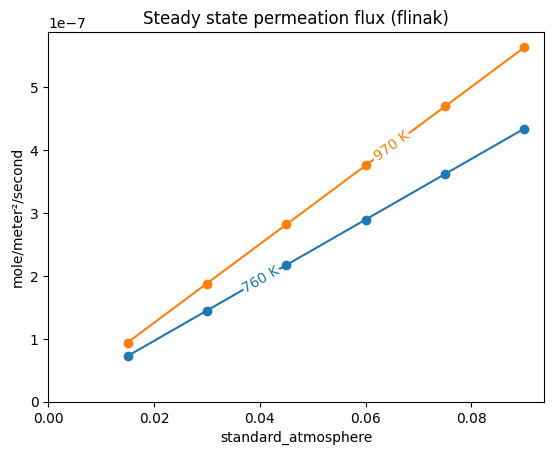

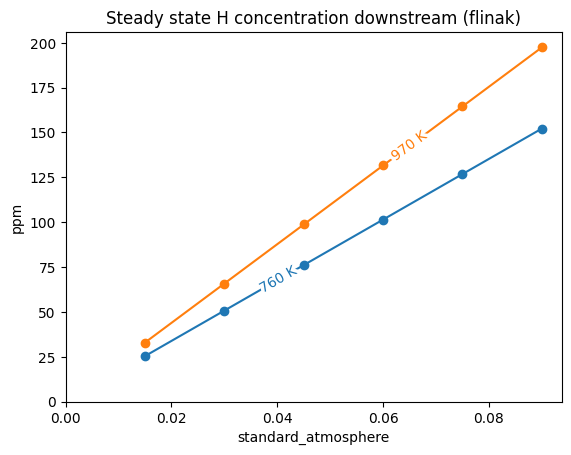

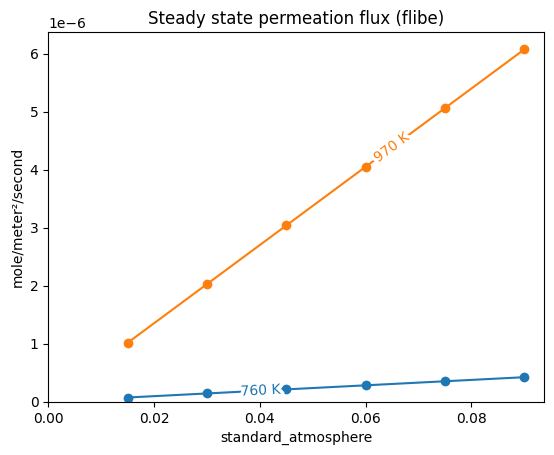

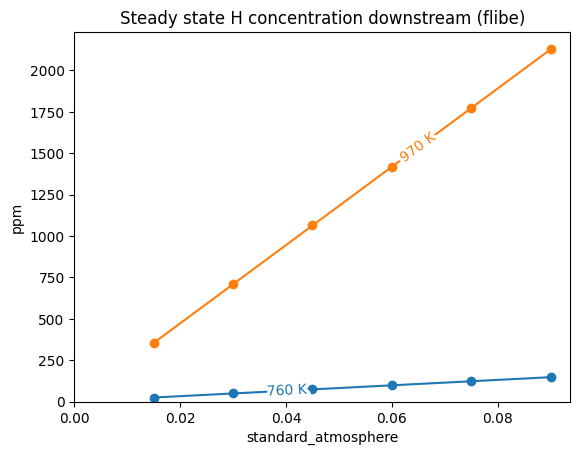

In [5]:
t_array = np.linspace(0, 6, num=500) * htm.ureg.h

total_cylinder_pressure = np.linspace(0.5, 3, num=6) * htm.ureg.atm # Represents pure hydrogen gas
pressures = total_cylinder_pressure * 0.03 # Represents the 3% hydrogen mixture

def steady_state_permeation_flux(pressures, permeability, diffusivity, thickness):
    fluxes=[]

    for P_up in pressures:
        flux = downstream_flux(t_array, P_up, permeability, thickness, diffusivity)[-1]
        fluxes.append(flux)
    fluxes = htm.ureg.Quantity.from_list(fluxes)
    return fluxes

def plot_steady_state_permeation_flux(pressures, permeability, diffusivity, thickness, **kwargs):
    fluxes = steady_state_permeation_flux(pressures, permeability, diffusivity, thickness)
    return plt.plot(pressures, fluxes, **kwargs)

def plot_steady_state_gas_concentration(pressures, permeability, diffusivity, thickness, **kwargs):
    fluxes = steady_state_permeation_flux(pressures, permeability, diffusivity, thickness)
    concentrations = []
    for flux in fluxes:
        concentration = sweep_gas_concentration(flux, area, sweep_rate)
        concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(htm.ureg.ppm)
        concentrations.append(concentration)

    concentrations = htm.ureg.Quantity.from_list(concentrations)

    return plt.plot(pressures, concentrations, **kwargs)

for mat, props in properties.items():
    permeability = props["permeability"]
    diffusivity = props["diffusivity"]
    plt.figure()
    plt.title(f'Steady state permeation flux ({mat})')
    plt.gca().yaxis.set_units(htm.ureg.mol * htm.ureg.m**-2 * htm.ureg.s**-1)
    for T in temperature_range:
        plot_steady_state_permeation_flux(pressures, permeability.value(T), diffusivity.value(T), L, marker="o", label=f"{T: ~P}")
    labelLines(plt.gca().get_lines())
    plt.ylim(bottom=0)
    plt.xlim(left=0)

    plt.figure()
    for T in temperature_range:
        plot_steady_state_gas_concentration(pressures, permeability.value(T), diffusivity.value(T), L, marker="o", label=f"{T: ~P}")
    plt.title(f'Steady state H concentration downstream ({mat})')
    labelLines(plt.gca().get_lines())
    plt.ylim(bottom=0)
    plt.xlim(left=0)
    plt.show()

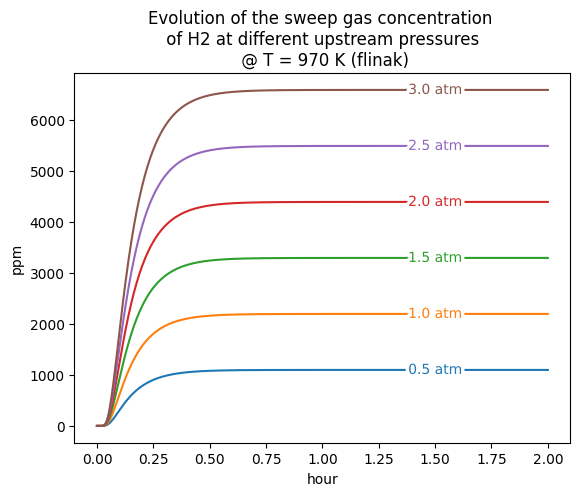

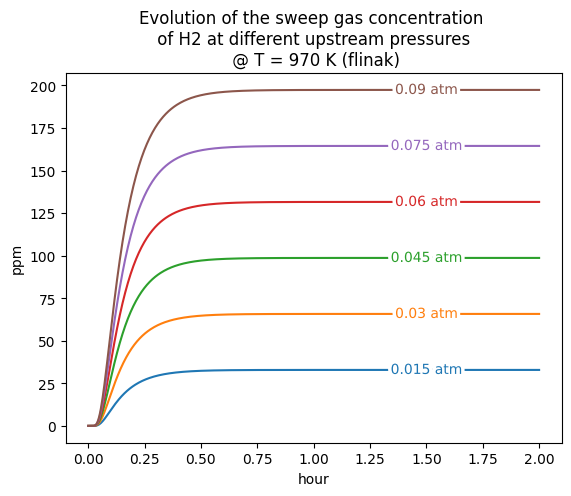

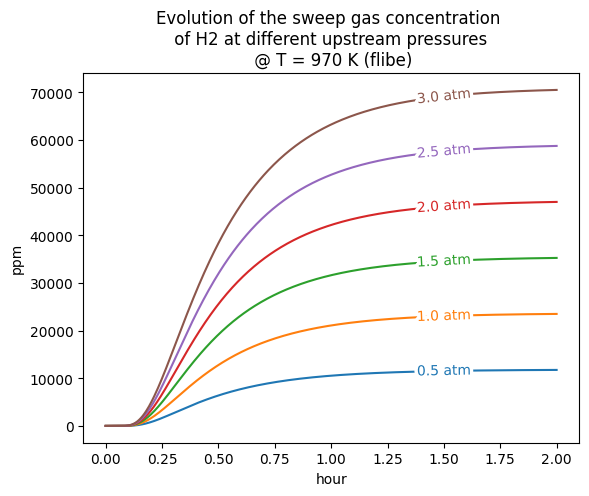

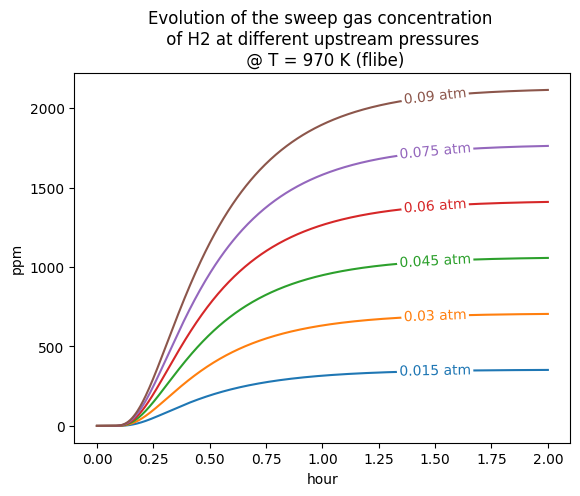

In [6]:

T = temperature_range[1]
t_array = np.linspace(0, 2, num=500) * htm.ureg.h

higher_pressures = np.linspace(0.5, 3, num=6) * htm.ureg.atm # Represents pure hydrogen gas
lower_pressures = higher_pressures * 0.03 # Represents the 3% hydrogen mixture

for mat, props in properties.items():
    permeability = props["permeability"]
    diffusivity = props["diffusivity"]

    for pressures in [higher_pressures, lower_pressures]:
        plt.figure()
        fluxes=[]
        concentrations = []
        for P_up in pressures:
            flux = downstream_flux(t_array, P_up, permeability.value(T), L, diffusivity.value(T))
            concentration = sweep_gas_concentration(flux, area, sweep_rate)
            concentration = concentration_to_ppm(concentration, MOLAR_MASS_H2, MOLAR_VOL_RT).to(htm.ureg.ppm)
            concentration[0] = 0
            plt.plot(t_array, concentration, label=f"{P_up:~P}")
        labelLines(plt.gca().get_lines(), xvals=[1.5] * 6)
        #plt.legend()
        plt.title(f"Evolution of the sweep gas concentration \n of H2 at different upstream pressures \n @ T = {T:~P} ({mat})")

### Now to think a little bit about deuterium and what results we should be expecting
There are no measurements for deuterium solubility and diffusivity in the literature unfortuantely, and not a lot that have measured both

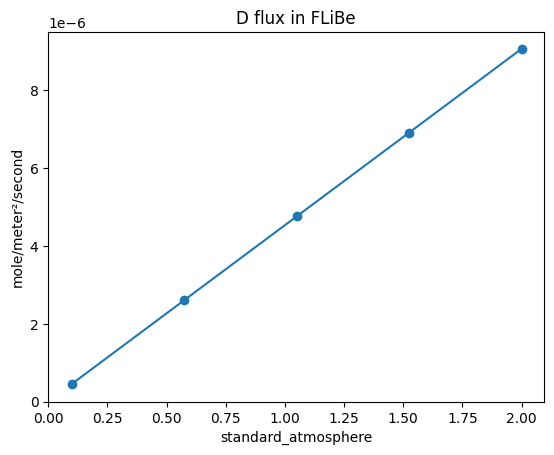

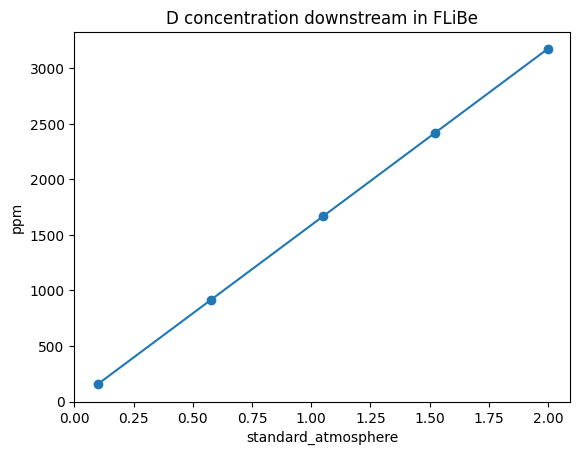

Text(0.5, 1.0, 'Evolution of the sweep gas concentration \n of D2 at different upstream pressures \n FLiBe')

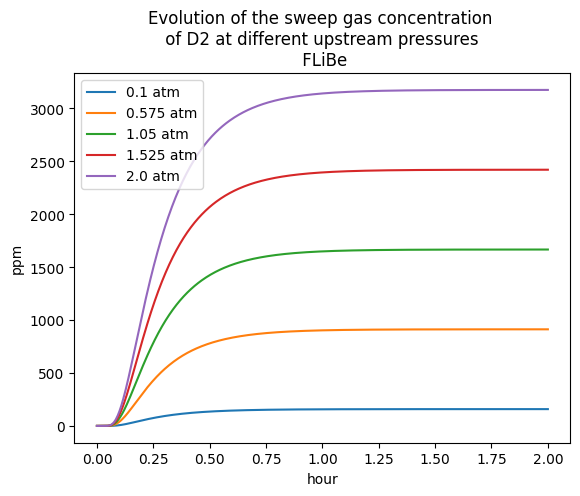

In [7]:

MOLAR_MASS_D2 = 2.014 * 2 * htm.ureg.g * htm.ureg.mol**-1

D_anderl = htm.diffusivities.filter(material=htm.FLIBE, author='anderl')[0]
K_H_anderl = htm.solubilities.filter(material=htm.FLIBE, author='anderl')[0]
perm_anderl = htm.ArrheniusProperty(
    pre_exp=D_anderl.pre_exp*K_H_anderl.pre_exp,
    act_energy=D_anderl.act_energy+K_H_anderl.act_energy
    )

# steady-state flux graphs

pressures = np.linspace(0.1, 2, num=5) * htm.ureg.atm
fluxes=[]
concentrations = []
for P_up in pressures:
    flux = downstream_flux(t_array, P_up, perm_anderl.value(T), L, D_anderl.value(T))[-1]
    fluxes.append(flux)
    concentration = (flux*area)/sweep_rate*MOLAR_MASS_D2
    concentrations.append((concentration*MOLAR_VOL_RT/MOLAR_MASS_D2).to(htm.ureg.ppm))

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(fluxes).to(htm.ureg.mol * htm.ureg.m**-2 * htm.ureg.s**-1), marker='o')
plt.title('D flux in FLiBe')
plt.ylim(bottom=0)
plt.xlim(left=0)

plt.figure()
plt.plot(pressures, htm.ureg.Quantity.from_list(concentrations), marker='o')
plt.title('D concentration downstream in FLiBe')
plt.ylim(bottom=0)
plt.xlim(left=0)
plt.show()

# transient flux graphs

fluxes=[]
concentrations = []
for P_up in pressures:
    flux = downstream_flux(t_array, P_up, perm_anderl.value(T), L, D_anderl.value(T))
    concentration = ((flux*area)/sweep_rate*MOLAR_MASS_D2).to(htm.ureg.mg*htm.ureg.meter**-3)
    concentration = ((concentration*MOLAR_VOL_RT/MOLAR_MASS_D2).to(htm.ureg.ppm))
    concentration[0] = 0
    plt.plot(t_array, concentration, label=f"{P_up:~P}")
plt.legend()
plt.title("Evolution of the sweep gas concentration \n of D2 at different upstream pressures \n FLiBe")